In [14]:
import geopandas as gpd, pandas as pd, requests
from shapely.geometry import box

# MSH bounding box
lat_center, lon_center = 46.1912, -122.1944
buffer_deg = .5  # e.g., ~50 km at this latitude for testing
minx, miny = lon_center - buffer_deg, lat_center - buffer_deg
maxx, maxy = lon_center + buffer_deg, lat_center + buffer_deg
bbox_geometry = box(minx, miny, maxx, maxy)
gf_bbox = gpd.GeoDataFrame({'name':['MSH bbox']}, geometry=[bbox_geometry], crs="EPSG:4326")

url = (
    "https://web-services.unavco.org/gps/metadata/sites/v1"
    f"?minlatitude={miny}&maxlatitude={maxy}"
    f"&minlongitude={minx}&maxlongitude={maxx}"
)
resp = requests.get(url, headers={"Accept":"application/json"}).json()
df = pd.DataFrame(resp)
gf_gps = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
print("Stations found:", gf_gps.shape[0])

Stations found: 285


In [15]:
gf_gps['id'].unique()

array(['P693', 'P695', 'P696', 'P697', 'P687', 'P698', 'P702', 'P421',
       'P690', 'P699', 'P689', 'P414', 'P692', 'P694', 'P691', 'P700',
       'P701', 'P703', 'P705', 'P431', 'P704', 'THAR', 'P688', 'P792',
       'JRO1', 'TGUA', 'TSTU', 'TWIW', 'TWRI', 'TSEP', 'SEPR'],
      dtype=object)

In [16]:
gf_gps.explore()

In [17]:
gf_gps.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    285 non-null    object  
 1   station_name          285 non-null    object  
 2   latitude              285 non-null    float64 
 3   longitude             285 non-null    float64 
 4   ellip_height          285 non-null    float64 
 5   monument_description  285 non-null    object  
 6   iersdomes             285 non-null    object  
 7   session_start_time    285 non-null    object  
 8   session_stop_time     285 non-null    object  
 9   antenna_type          285 non-null    object  
 10  dome_type             285 non-null    object  
 11  antenna_sn            285 non-null    object  
 12  ant_dz                285 non-null    float64 
 13  ant_dn                285 non-null    float64 
 14  ant_de                285 non-null    float64 
 15

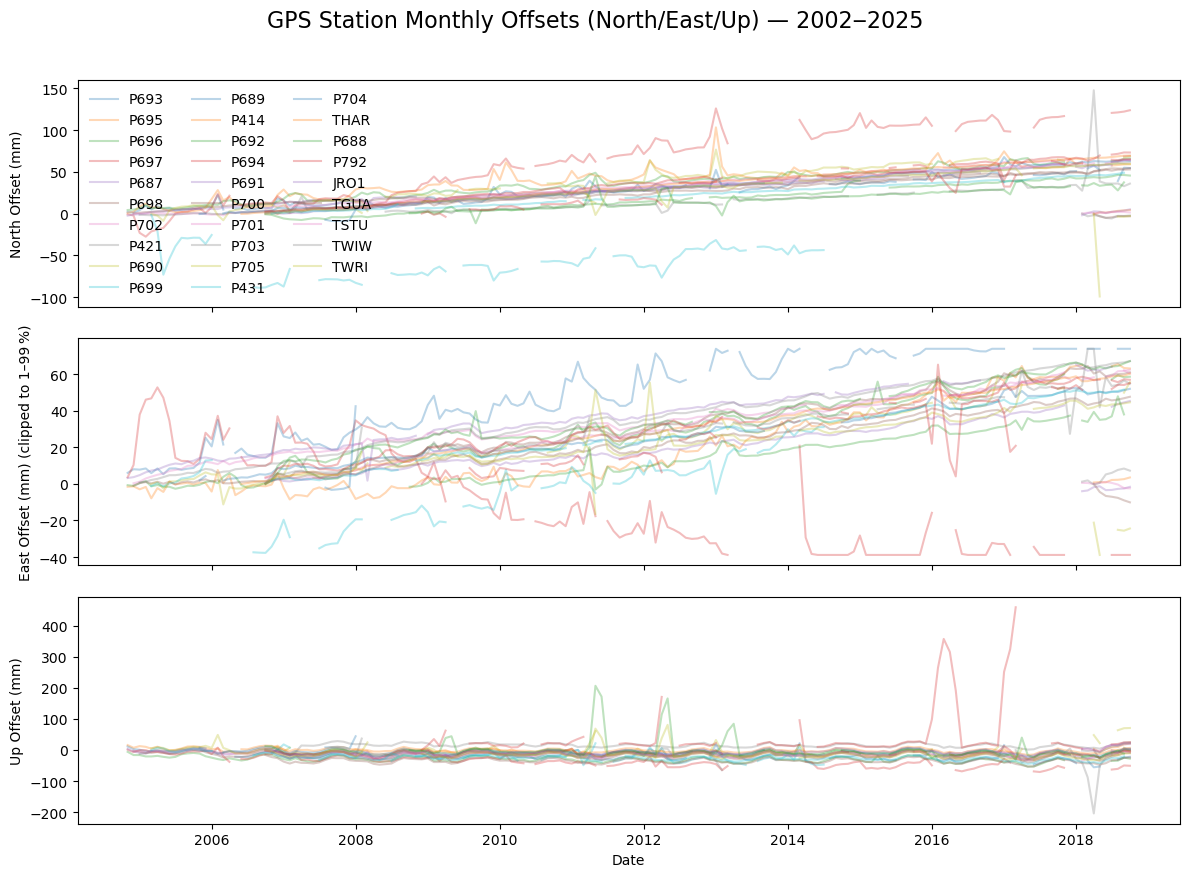

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
station_ids = gf_gps['id'].tolist()
monthly_data = {}

for station in station_ids:
    url = (
        f"https://web-services.unavco.org/gps/data/position/{station}/v3"
        "?analysisCenter=pbo"
        "&referenceFrame=NAM08"
        "&report=short"
        "&refCoordOption=first_epoch"
        "&starttime=2002-01-01T00:00:00Z"
        "&endtime=2025-05-05T00:00:00Z"
    )
    try:
        df = pd.read_csv(url, comment='#', parse_dates=['Datetime'])
    except Exception:
        continue

    df.rename(columns=lambda c: c.strip(), inplace=True)
    df.set_index('Datetime', inplace=True)
    monthly = (
        df[['delta N', 'delta E', 'delta U']]
        .resample('ME').mean()  # month‑end
        * 1000.0                # meters -> mm
    ).rename(columns={'delta N':'north','delta E':'east','delta U':'up'})

    monthly_data[station] = monthly

# 2) Concatenate to compute the 1st and 99th percentiles for 'east'
all_east = pd.concat([m['east'] for m in monthly_data.values()])
low_east, high_east = np.nanpercentile(all_east, [1, 99])

# 3) Plot with clipping, title, and larger legend
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 9))
fig.suptitle("GPS Station Monthly Offsets (North/East/Up) — 2002‒2025", fontsize=16, y=0.97)

for station, monthly in monthly_data.items():
    # clip East outliers to the 1–99% range
    monthly['east_clipped'] = monthly['east'].clip(lower=low_east, upper=high_east)

    for ax, comp in zip(axes, ['north', 'east_clipped', 'up']):
        ax.plot(monthly.index, monthly[comp], alpha=0.3, label=station)

titles = ['North Offset (mm)', 'East Offset (mm) (clipped to 1–99 %)', 'Up Offset (mm)']
for ax, title in zip(axes, titles):
    ax.set_ylabel(title)
axes[-1].set_xlabel('Date')

axes[0].legend(ncol=3, fontsize='medium', loc='upper left', frameon=False)

plt.tight_layout(rect=[0,0,1,0.95]);